# Le Meilleur Data Scientist de France 2018

Created on 31-05-2018

@author: Hakim Idjis

Top 10 solution.

# Context

[Label Emmaüs](https://www.label-emmaus.co/fr/) offers for sale objects renovated or created by the movement
Emmaüs. The purpose of this challenge is to estimate the time to sale of each object.

The task is a **Multiclass classification**, with 3 classes:

* 0 : between 0 et 10 days
* 1 : between 10 et 60 days
* 2 : more than 60 days

The evaluation metric is **multilogloss** 


# Loading libraries

In [1]:
import sys
print ('python :', sys.version)
import pandas as pd
print('pandas :', pd.__version__)
import numpy as np
print('numpy :', np.__version__)
import sklearn
print('sklearn :', sklearn.__version__)
import lightgbm as lgb
print('lightgbm :', lgb.__version__)
##############################################
import os, gc
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import log_loss 
from sklearn.cross_validation import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords 
from contextlib import contextmanager
from time import time
t0 = time()

python : 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]
pandas : 0.20.3
numpy : 1.13.3
sklearn : 0.19.1
lightgbm : 2.1.0


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Loading data

In [2]:
train = pd.read_csv('input/X_train.csv', index_col=0, error_bad_lines=False)
test = pd.read_csv('input/X_test.csv', index_col=0, error_bad_lines=False)
y = pd.read_csv("input/y_train.csv", index_col=0)
y = np.ravel(y)
test_ind = test.index
print('train shape = {}, test shape = {}'.format(train.shape, test.shape))

train shape = (8880, 30), test shape = (2960, 30)


b'Skipping line 2168: expected 31 fields, saw 33\nSkipping line 4822: expected 31 fields, saw 37\nSkipping line 4859: expected 31 fields, saw 37\nSkipping line 7342: expected 31 fields, saw 37\n'


In [3]:
ntrain = train.shape[0]
train_test = pd.concat([train, test], axis = 0).reset_index(drop=True)
print('train_test shape = {}'.format(train_test.shape))
del(train, test); gc.collect()

tdp = ['url_image', 'sous_categorie_4']
train_test.drop(tdp, axis = 1, inplace = True)


train_test shape = (11840, 30)


# Feature Engineering

In [4]:
@contextmanager
def timer(name):
    t0 = time()
    print('\nstarting :', name)
    yield
    if time() - t0 < 120:
      print('done in', round(time() - t0, 1),  's')
    else:
      print('done in ', round((time() - t0)/60, 1), 'm')

In [5]:
# label encode categorical features
def lebel_encode(df, cat_cols):
  with timer('Label Encoding'):
    for c in cat_cols:
      df[c] = LabelEncoder().fit_transform(df[c].values.astype('str'))
  return(df)
  
lim_cat_nunic = 200
cat_cols = [f for f in train_test.columns if train_test[f].dtype == 'O' and train_test[f].nunique() < lim_cat_nunic]
train_test = lebel_encode(train_test.copy(), cat_cols)


starting : Label Encoding
done in 0.1 s


In [6]:
## Add count of words and characters for text columns
def char_word_counts(df, text_cols, remove_origin = False):
  with timer('Text Features'):
    for col in text_cols:
      df[col] = df[col].astype(str).fillna('').str.lower()
      df[col + '_num_chars'] = df[col].apply(len) 
      df[col + '_num_words'] = df[col].apply(lambda comment: len(comment.split())) 
    if remove_origin:
      df = df.drop(text_cols, axis=1)
  return(df)
  
text_cols = [f for f in train_test.columns if train_test[f].dtype == 'O' and train_test[f].nunique() >= lim_cat_nunic]
train_test = char_word_counts(train_test.copy(), text_cols, remove_origin = False)


starting : Text Features
done in 0.3 s


In [7]:
## Bag of words for text columns
with timer('bag of words'):
    vec_txt_feats = []
    vec_txt_feats_names = []
    for f in text_cols:
      train_test[f].fillna('missing', inplace = True)
      vec_txt_feat = CountVectorizer(stop_words= set(stopwords.words('french')),
                                     token_pattern= r'\w{1,}', 
                                     max_features= 500, ngram_range=(1, 2))
      vec_txt_feat.fit(train_test[f])
      vec_txt_feats.append(vec_txt_feat.transform(train_test[f]))
      vec_txt_feats_names.extend(vec_txt_feat.get_feature_names())  


starting : bag of words
done in 4.4 s


In [8]:
## concatenate train_test features with sparse text ones
with timer('concatenating'):
    train_test.drop(text_cols, axis=1,inplace=True)
    features = list(train_test.columns) + vec_txt_feats_names
    for i in range(len(vec_txt_feats)):
      train_test = hstack((train_test, vec_txt_feats[i])).tocsr()
    del(vec_txt_feats); gc.collect()

train, test = train_test[:ntrain, :], train_test[ntrain:, :]
del(train_test); gc.collect()


starting : concatenating
done in 0.2 s


0

# Training

In [9]:
def run_lgb(xtr, ytr, xte, yte, test, params, f_names, cat_cols, num_rounds=100000, e_s_r = 50):  
    model = lgb.train(params, 
                      lgb.Dataset(xtr, label=ytr, feature_name=f_names,categorical_feature=cat_cols), 
                      num_rounds,
                      lgb.Dataset(xte, label=yte, feature_name=f_names,categorical_feature=cat_cols), 
                      verbose_eval=50, early_stopping_rounds=e_s_r)
                  
    pred_yte = model.predict(xte, num_iteration=model.best_iteration)
    pred_test = model.predict(test, num_iteration=model.best_iteration) 
    return pred_yte, pred_test, model

lgb_params = {"objective" : "multiclass", 
              "num_class":3,
              "metric" : "multi_logloss", 
              "num_leaves" : 30, 
              "learning_rate" : 0.1, 
              "bagging_fraction" : 0.7, 
              "feature_fraction" : 0.5,
              "bagging_frequency" : 5, 
              "bagging_seed" : 2018}

In [10]:
nfolds = 5
test_pred = np.zeros((test.shape[0], 3))
pred_oof = np.zeros((train.shape[0], 3))
scores, times = np.zeros(nfolds), np.zeros(nfolds)
i=0
kf= StratifiedKFold(y, nfolds, shuffle=True, random_state=111)
for (dev_index, val_index) in kf:
    print ('**********  starting fold {} *********'.format(i+1))
    t1 = time()       
    xtr, xte = train[dev_index,:], train[val_index,:]
    ytr, yte = y[dev_index], y[val_index] 
    
    pred, test_pred_cv, model = run_lgb(xtr, ytr, xte, yte, test, lgb_params, features, cat_cols)

    test_pred += test_pred_cv / nfolds
    pred_oof[val_index] = pred
    scores[i], times[i] = log_loss(yte, pred), round((time()-t1), 0)
    print('Fold ', i+1, 'log_loss =  :', scores[i], times[i], "s")
    i+=1

total_score = round(log_loss(y, pred_oof), 4)
print('Total score:', total_score,'mean score:', round(np.mean(scores), 4), 'std :', round(np.std(scores), 4))

**********  starting fold 1 *********


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 50 rounds.
[50]	valid_0's multi_logloss: 0.938242
[100]	valid_0's multi_logloss: 0.929814
[150]	valid_0's multi_logloss: 0.934462
Early stopping, best iteration is:
[109]	valid_0's multi_logloss: 0.928803
Fold  1 log_loss =  : 0.928803422425 6.0 s
**********  starting fold 2 *********
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's multi_logloss: 0.943509
[100]	valid_0's multi_logloss: 0.936561
Early stopping, best iteration is:
[91]	valid_0's multi_logloss: 0.936286
Fold  2 log_loss =  : 0.936272461097 6.0 s
**********  starting fold 3 *********
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's multi_logloss: 0.95316
[100]	valid_0's multi_logloss: 0.94995
Early stopping, best iteration is:
[97]	valid_0's multi_logloss: 0.949329
Fold  3 log_loss =  : 0.949329140188 6.0 s
**********  starting fold 4 *********
Training until validation scores don't improve for 50 rounds.
[50]	valid_

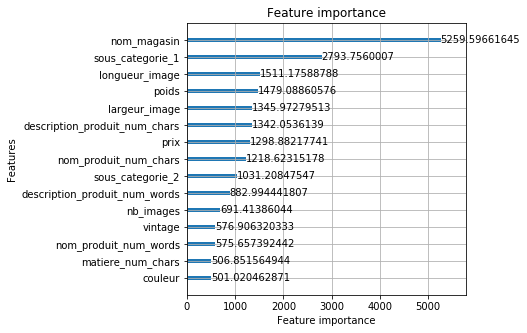

In [11]:
lgb.plot_importance(model, figsize=(5, 5), max_num_features=15, importance_type= 'gain')

# Submission

In [12]:
sub = pd.DataFrame(test_pred, index=test_ind)
sub.to_csv("lgb_"+str(total_score)+".csv", index_label="id", header=['0', '1', '2'])

print("Total time = %.f s"% (time()-t0))

Total time = 37 s
